In [47]:
using CairoMakie
CairoMakie.activate!()

In [17]:
using HDF5
using Random: AbstractRNG
using DensityInterface
using Distributions
using Distributions: logpdf, pdf, Normal, Gamma, fit
import Optim: LBFGS, minimizer, optimize
using StatsBase
using ZebrafishHMM2023: DistributionMissingWrapper

# Functions and stuff

In [2]:
struct SignedGamma
    gamma::Gamma{Float64}
    positive::Bool
end

function SignedGamma(gamma::Gamma; positive::Bool)
    return SignedGamma(gamma, positive)
end

function SignedGamma(α::Real, θ::Real; positive::Bool)
    return SignedGamma(Gamma(α, θ); positive)
end

function Base.rand(r::AbstractRNG, d::SignedGamma)
    if d.positive
        return rand(r, d.gamma)
    else
        return -rand(r, d.gamma)
    end
end
function Base.rand(r::AbstractRNG, d::SignedGamma, n::Int)
    if d.positive
        return rand(r, d.gamma, n)
    else
        return -rand(r, d.gamma, n)
    end
end

function DensityInterface.logdensityof(d::SignedGamma, x::Real)
    if d.positive
        return logpdf(d.gamma, x)
    else
        return logpdf(d.gamma, -x)
    end
end

function Distributions.pdf(d::SignedGamma, x::AbstractArray)
    if d.positive
        return pdf.(d.gamma, x)
    else
        return pdf.(d.gamma, -x)
    end
end

In [3]:
function sample_mixture(ds::Vector{Any}, weights::Vector{Float64}; N::Int=10000)
    samples = Matrix{Float64}(undef, (N,length(ds)))
    for i in 1:length(ds)
        samples[:,i] .= rand(ds[i], N)
    end
    inds = sample([1,2,3], Weights(weights), N)
    return [samples[i,inds[i]] for i in 1:N]
end

sample_mixture (generic function with 1 method)

# Data

In [4]:
TEMPS = [18,22,26,30,33];

In [5]:
data_path = "/SEC/ZebraFish/Tools_Analysis/IBIO-Banyuls2023-Python/content/banyuls_data/behaviour_free_swimming.h5"

"/SEC/ZebraFish/Tools_Analysis/IBIO-Banyuls2023-Python/content/banyuls_data/behaviour_free_swimming.h5"

In [6]:
function load_all_dtheta(T::Int)
    dtheta = h5read(data_path, "behaviour/$(T)/dtheta")
    all_trajs = collect(eachcol(replace(dtheta, NaN => missing, 0 => missing)));
    flat_trajs = reduce(vcat, [a[:,1] for a in all_trajs]);
    flat_trajs = Float64.(flat_trajs[findall(!ismissing,flat_trajs)]);
    return flat_trajs
end

load_all_dtheta (generic function with 1 method)

# Output File

In [7]:
out_path = "data_/mixtures.h5"

"data_/mixtures.h5"

In [35]:
# create file structure
outf = h5open(out_path, "w")
for t in TEMPS
    grp = create_group(outf, "$(t)")
    create_group(grp, "Gamma-Normal-Gamma")
    create_group(grp, "Normal-Normal-Normal")
    create_group(grp, "TruncNormal-Normal-TruncNormal")
end
close(outf)

# Mixture Models

## Gamma-Normal-Gamma

In [18]:
function ll(data::Vector, Nσ::Real, Gα::Real, Gβ::Real, mix::Vector)
    F = Normal(0,Nσ)
    R = SignedGamma(Gα,Gβ;positive=true)
    L = SignedGamma(Gα,Gβ;positive=false)
    a = mix[1].*pdf.(F,data) .+ mix[2].*pdf(R,-data) .+ mix[3].*pdf(L,-data);
    return log.(a)
end

ll (generic function with 1 method)

In [38]:
outf = h5open(out_path, "cw")
for t in TEMPS
    println("loading $(t)°C")
    data = load_all_dtheta(t)

    println("optimizing $(t)°C")
    function nll(Θ::Vector)
        return -sum(ll(data, Θ[1], Θ[2], Θ[3], [Θ[4],(1-Θ[4])/2,(1-Θ[4])/2]))
    end
    θ0 = [3.4542, 2.562, 13.861, 0.5379]
    res = optimize(
        nll, 
        [1.e-5, 1.e-5, 1.e-5, 1.e-5],
        [100, 100, 100, 1-1.e-5],
        θ0,
    )
    θ = minimizer(res)
    Nσ = θ[1]
    Gα = θ[2]
    Gβ = θ[3]
    mix = [ θ[4], (1-θ[4])/2, (1-θ[4])/2 ]

    println("Sampling $(t)°C")
    F = Normal(0,Nσ)
    R = SignedGamma(Gα,Gβ;positive=true)
    L = SignedGamma(Gα,Gβ;positive=false)
    sampl = sample_mixture([F,R,L], mix; N=100000);
    qq = qqbuild(data, sampl)

    println("Saving $(t)°C")
    grp = outf["$(t)/Gamma-Normal-Gamma"]
    grp["σ"] = Nσ
    grp["α"] = Gα
    grp["β"] = Gβ
    grp["weights"] = mix
    grp["QQx"] = qq.qx
    grp["QQy"] = qq.qy
end
close(outf)

loading 18°C
optimizing 18°C
Sampling 18°C
Saving 18°C
loading 22°C
optimizing 22°C
Sampling 22°C
Saving 22°C
loading 26°C
optimizing 26°C
Sampling 26°C
Saving 26°C
loading 30°C
optimizing 30°C
Sampling 30°C
Saving 30°C
loading 33°C
optimizing 33°C
Sampling 33°C
Saving 33°C


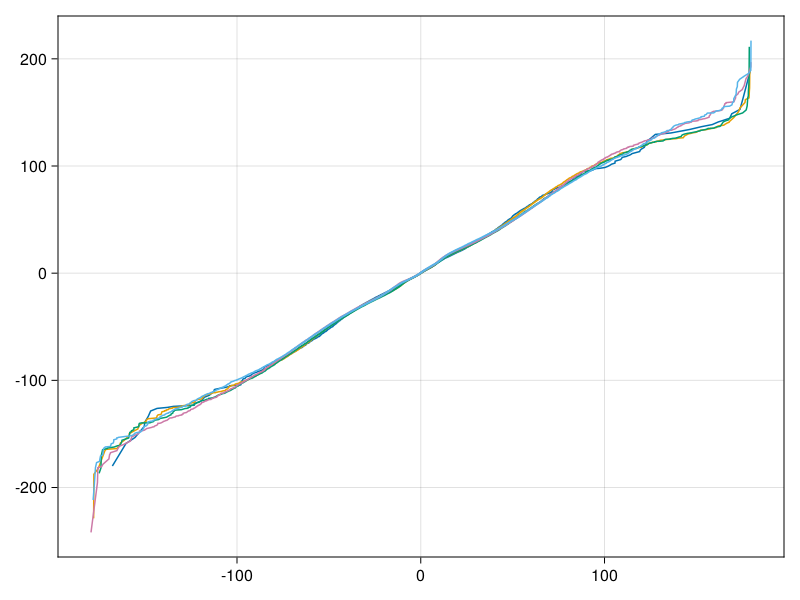

In [51]:
outf = h5open(out_path, "r")

fig = Figure()
ax = Axis(fig[1,1])
for t in TEMPS
    lines!(ax, outf["$(t)/Gamma-Normal-Gamma/QQx"][:], outf["$(t)/Gamma-Normal-Gamma/QQy"][:])
end

close(outf)
fig

## Normal-Normal-Normal

In [83]:
function ll(data::Vector, Fσ::Real, Tσ::Real, Tμ::Real, mix::Vector)
    F = Normal(0,Fσ)
    R = Normal(Tμ,Tσ)
    L = Normal(-Tμ,Tσ)
    a = mix[1].*pdf.(F,data) .+ mix[2].*pdf.(R,data) .+ mix[3].*pdf.(L,data);
    return log.(a)
end

ll (generic function with 1 method)

In [100]:
outf = h5open(out_path, "cw")
for t in TEMPS
    println("loading $(t)°C")
    data = load_all_dtheta(t)

    println("optimizing $(t)°C")
    function nll(Θ::Vector)
        return -sum(ll(data, Θ[1], Θ[2], Θ[3], [Θ[4],(1-Θ[4])/2,(1-Θ[4])/2]))
    end
    θ0 = [10, 25, 30, 0.5]
    res = optimize(
        nll, 
        [1.e-5, 1.e-5, 1.e-5, 1.e-5],
        [100, 100, 100, 1-1.e-5],
        θ0,
    )
    θ = minimizer(res)
    Fσ = θ[1]
    Tσ = θ[2]
    Tμ = θ[3]
    mix = [ θ[4], (1-θ[4])/2, (1-θ[4])/2 ]

    println("Sampling $(t)°C")
    F = Normal(0,Fσ)
    R = Normal(Tμ,Tσ)
    L = Normal(-Tμ,Tσ)
    sampl = sample_mixture(Vector{Any}([F,R,L]), mix; N=100000);
    qq = qqbuild(data, sampl)

    println("Saving $(t)°C")
    grp = outf["$(t)/Normal-Normal-Normal"]
    grp["Fσ"] = Fσ
    grp["Tσ"] = Tσ
    grp["Tμ"] = Tμ
    grp["weights"] = mix
    grp["QQx"] = qq.qx
    grp["QQy"] = qq.qy
end
close(outf)

loading 18°C
optimizing 18°C
Sampling 18°C
Saving 18°C
loading 22°C
optimizing 22°C
Sampling 22°C
Saving 22°C
loading 26°C
optimizing 26°C
Sampling 26°C
Saving 26°C
loading 30°C
optimizing 30°C
Sampling 30°C
Saving 30°C
loading 33°C
optimizing 33°C
Sampling 33°C
Saving 33°C


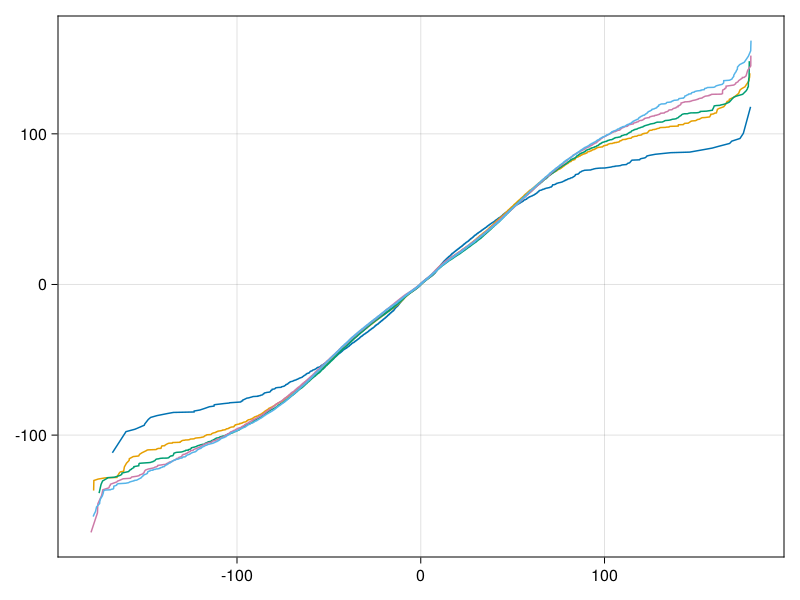

In [103]:
outf = h5open(out_path, "r")

fig = Figure()
ax = Axis(fig[1,1])
for t in TEMPS
    lines!(ax, outf["$(t)/Normal-Normal-Normal/QQx"][:], outf["$(t)/Normal-Normal-Normal/QQy"][:])
end

close(outf)
fig

## TruncNormal-Normal-TruncNormal

In [107]:
function ll(data::Vector, Fσ::Real, Tσ::Real, Tμ::Real, Tτ::Real ,mix::Vector)
    F = Normal(0,Fσ)
    R = truncated(Normal(Tμ,Tσ); lower=Tτ, upper=Inf)
    L = truncated(Normal(-Tμ,Tσ); lower=-Inf, upper=-Tτ)
    a = mix[1].*pdf.(F,data) .+ mix[2].*pdf.(R,data) .+ mix[3].*pdf.(L,data);
    return log.(a)
end

ll (generic function with 2 methods)

In [118]:
outf = h5open(out_path, "cw")
for t in TEMPS
    println("loading $(t)°C")
    data = load_all_dtheta(t)

    println("optimizing $(t)°C")
    function nll(Θ::Vector)
        return -sum(ll(data, Θ[1], Θ[2], Θ[3], Θ[4], [Θ[5],(1-Θ[5])/2,(1-Θ[5])/2]))
    end
    θ0 = [10, 25, 30, 1.e-5, 0.5]
    res = optimize(
        nll, 
        [1.e-5, 1.e-5, 1.e-5, 1.e-5, 1.e-5],
        [100, 100, 100, 50, 1-1.e-5],
        θ0,
    )
    θ = minimizer(res)
    Fσ = θ[1]
    Tσ = θ[2]
    Tμ = θ[3]
    Tτ = θ[4]
    mix = [ θ[5], (1-θ[5])/2, (1-θ[5])/2 ]

    println("Sampling $(t)°C")
    F = Normal(0,Fσ)
    R = truncated(Normal(Tμ,Tσ); lower=Tτ, upper=Inf)
    L = truncated(Normal(-Tμ,Tσ); lower=-Inf, upper=-Tτ)
    sampl = sample_mixture(Vector{Any}([F,R,L]), mix; N=100000);
    qq = qqbuild(data, sampl)

    println("Saving $(t)°C")
    grp = outf["$(t)/TruncNormal-Normal-TruncNormal"]
    grp["Fσ"] = Fσ
    grp["Tσ"] = Tσ
    grp["Tμ"] = Tμ
    grp["Tτ"] = Tτ
    grp["weights"] = mix
    grp["QQx"] = qq.qx
    grp["QQy"] = qq.qy
end
close(outf)

loading 18°C
optimizing 18°C


┌ Warning: Initial position cannot be on the boundary of the box. Moving elements to the interior.
│ Element indices affected: [4]
└ @ Optim ~/.julia/packages/Optim/V8ZEC/src/multivariate/solvers/constrained/fminbox.jl:314


Sampling 18°C
Saving 18°C
loading 22°C
optimizing 22°C


┌ Warning: Initial position cannot be on the boundary of the box. Moving elements to the interior.
│ Element indices affected: [4]
└ @ Optim ~/.julia/packages/Optim/V8ZEC/src/multivariate/solvers/constrained/fminbox.jl:314


Sampling 22°C
Saving 22°C
loading 26°C
optimizing 26°C


┌ Warning: Initial position cannot be on the boundary of the box. Moving elements to the interior.
│ Element indices affected: [4]
└ @ Optim ~/.julia/packages/Optim/V8ZEC/src/multivariate/solvers/constrained/fminbox.jl:314


Sampling 26°C
Saving 26°C
loading 30°C
optimizing 30°C


┌ Warning: Initial position cannot be on the boundary of the box. Moving elements to the interior.
│ Element indices affected: [4]
└ @ Optim ~/.julia/packages/Optim/V8ZEC/src/multivariate/solvers/constrained/fminbox.jl:314


Sampling 30°C
Saving 30°C
loading 33°C
optimizing 33°C


┌ Warning: Initial position cannot be on the boundary of the box. Moving elements to the interior.
│ Element indices affected: [4]
└ @ Optim ~/.julia/packages/Optim/V8ZEC/src/multivariate/solvers/constrained/fminbox.jl:314


Sampling 33°C
Saving 33°C


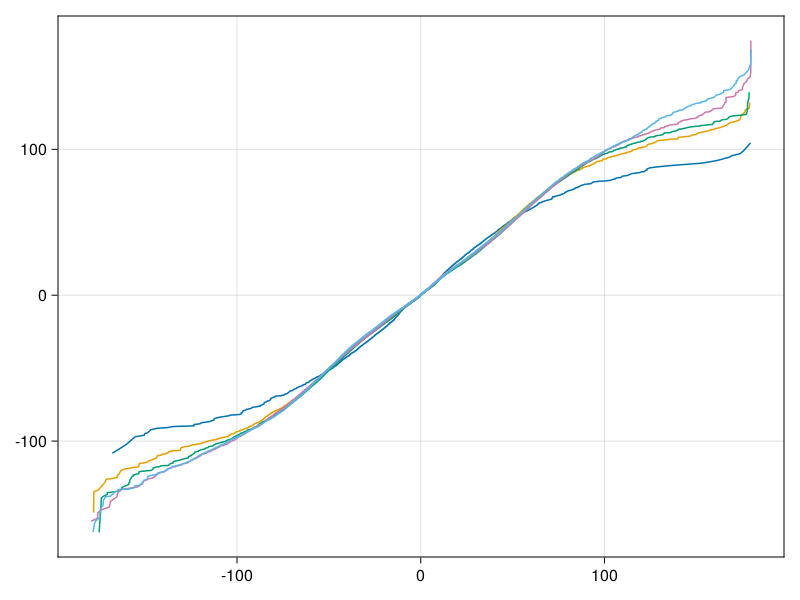

In [119]:
outf = h5open(out_path, "r")

fig = Figure()
ax = Axis(fig[1,1])
for t in TEMPS
    lines!(ax, outf["$(t)/TruncNormal-Normal-TruncNormal/QQx"][:], outf["$(t)/TruncNormal-Normal-TruncNormal/QQy"][:])
end

close(outf)
fig